# Data analysis
In this iPython notebook, we analyse the data produced by the basic stock market model

In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import ast
style.use('seaborn-darkgrid')

First, I open a connection to the database

In [2]:
conn = sqlite3.connect('dataBaseOffline.sqlite')
cur = conn.cursor()

## 1 State variables 
Using the Statevariables, Variabletypes and Objects tables, I then analyse the state variables of the simulated objects: stocks, firms, and traders. 
### 1.1 Stocks 
The state variables of stocks are: 
* the firm the stock links to,
* the face value,
* the amount of stocks outstanding. 

In this version of the model these variables are static. 

In [3]:
stockVariables = pd.read_sql_query(
    """
    SELECT Statevariables.period, Variabletypes.variable_type, Objects.object_name, Objects.object_type ,Statevariables.value 
    FROM Statevariables JOIN Variabletypes JOIN Objects ON Statevariables.variable_id = Variabletypes.id and Statevariables.owner_id = Objects.id 
    WHERE Objects.object_type = 'stock'
    """, conn)

In [4]:
stockVariables.tail()

,period,variable_type,object_name,object_type,value
1195,99,amount,stock_1,stock,200.0
1196,99,firm,stock_2,stock,2.0
1197,99,name,stock_2,stock,2.0
1198,99,face_value,stock_2,stock,50.0
1199,99,amount,stock_2,stock,200.0


In [5]:
stock_0 = stockVariables.query('variable_type == "amount" and object_name == "stock_0"')['value']
stock_1 = stockVariables.query('variable_type == "amount" and object_name == "stock_1"')['value']
stock_2 = stockVariables.query('variable_type == "amount" and object_name == "stock_2"')['value']
#stock_3 = stockVariables.query('variable_type == "amount" and object_name == "stock_3"')['value']
time = stockVariables.query('variable_type == "amount" and object_name == "stock_0"')['period']

In [6]:
face_value_0 = stockVariables.query('variable_type == "face_value" and object_name == "stock_0"')['value']
face_value_1 = stockVariables.query('variable_type == "face_value" and object_name == "stock_1"')['value']
face_value_2 = stockVariables.query('variable_type == "face_value" and object_name == "stock_2"')['value']
#face_value_3 = stockVariables.query('variable_type == "face_value" and object_name == "stock_3"')['value']

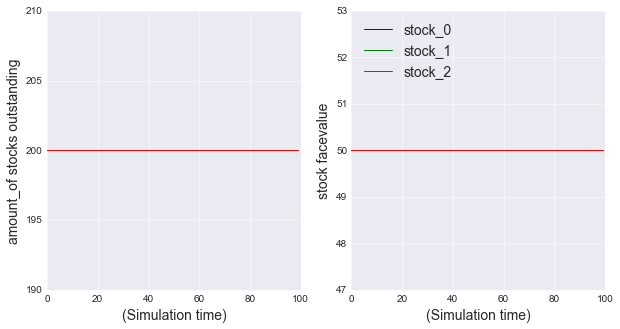

In [7]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(time, stock_0, label='stock_0')
ax1.plot(time, stock_1, label='stock_1')
ax1.plot(time, stock_2, label='stock_2')
#ax1.plot(time, stock_3, label='stock_3')

ax2.plot(time, face_value_0, label='stock_0')
ax2.plot(time, face_value_1, label='stock_1')
ax2.plot(time, face_value_2, label='stock_2')
#ax2.plot(time, face_value_3, label='stock_3')

ax1.set_xlabel('(Simulation time)', fontsize='14')
ax2.set_xlabel('(Simulation time)', fontsize='14')
ax1.set_ylabel('amount_of stocks outstanding', fontsize='14')
ax2.set_ylabel('stock facevalue', fontsize='14')

plt.legend(loc=2, fontsize='14')

### 1.2 Firms 
The state variables of firms are: 
* profit
* Bookvalue,
* Dividend rate.

In [8]:
firmVariables = pd.read_sql_query(
    """
    SELECT Statevariables.period, Variabletypes.variable_type, Objects.object_name, Objects.object_type, Statevariables.value 
    FROM Statevariables JOIN Variabletypes JOIN Objects 
    ON Statevariables.variable_id = Variabletypes.id and Statevariables.owner_id = Objects.id 
    WHERE Objects.object_type = 'firm'
    """, conn)

In [9]:
firmVariables.head(5)

,period,variable_type,object_name,object_type,value
0,0,profit,firm_0,firm,210
1,0,profit_history,firm_0,firm,"[150, 170, 190, 200, 210]"
2,0,name,firm_0,firm,0
3,0,profit_growth_history,firm_0,firm,"[0.1333333333333333, 0.11764705882352944, 0.05..."
4,0,book_value,firm_0,firm,10000


In [10]:
firm_0 = firmVariables.query('variable_type == "profit" and object_name == "firm_0"')['value']
firm_1 = firmVariables.query('variable_type == "profit" and object_name == "firm_1"')['value']
firm_2 = firmVariables.query('variable_type == "profit" and object_name == "firm_2"')['value']
#firm_3 = firmVariables.query('variable_type == "profit" and object_name == "firm_3"')['value']
f_time = firmVariables.query('variable_type == "profit" and object_name == "firm_0"')['period']

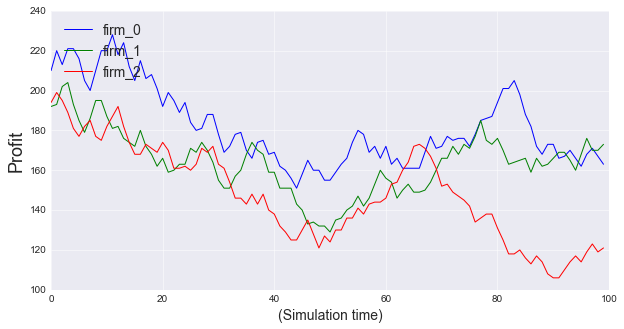

In [11]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

ax1.plot(f_time, firm_0, label='firm_0')
ax1.plot(f_time, firm_1, label='firm_1')
ax1.plot(f_time, firm_2, label='firm_2')
#ax1.plot(f_time, firm_3, label='firm_3')

ax1.set_xlabel('(Simulation time)', fontsize='14')
ax1.set_ylabel('Profit', fontsize='18')

plt.legend(loc=2, fontsize='14')

### 1.3 Traders

In this section, we examine the state variables of traders. These are: 
* Money
* Portfolio of stocks: *The type and amount of that stock agent holds*
* Bid-ask spread: *the percentage difference between the amount at which an agent is willing to buy and sell a stock.*
* Memory size: *the amount of periods an agent remembers stock prices*

In [12]:
traderVariables = pd.read_sql_query(
    """
    SELECT Statevariables.period, Variabletypes.variable_type, Objects.object_name, Objects.object_type, Statevariables.value 
    FROM Statevariables JOIN Variabletypes JOIN Objects 
    ON Statevariables.variable_id = Variabletypes.id and Statevariables.owner_id = Objects.id 
    WHERE Objects.object_type = 'trader'
    """, conn)

In [13]:
traderVariables.tail()

,period,variable_type,object_name,object_type,value
5995,99,money,trader_7,trader,197.733
5996,99,name,trader_7,trader,7
5997,99,memory_size,trader_7,trader,1
5998,99,bid_ask_spread,trader_7,trader,5
5999,99,stocks,trader_7,trader,"{'stock_0': 0, 'stock_1': 0, 'stock_2': 0}"


In [14]:
trader_0 = traderVariables.query('variable_type == "money" and object_name == "trader_0"')['value']
t_time = traderVariables.query('variable_type == "money" and object_name == "trader_0"')['period']

### Money:
Over time some traders trade more than other and thus their **money** either increases or decreases. All traders start out with money between 200 and 250 and over time this branches out to a distribution between 0 and 280. 

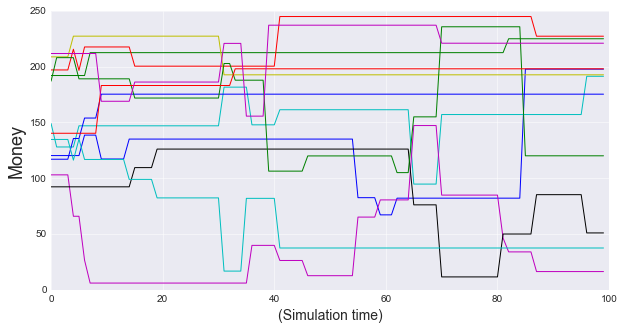

In [15]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

for trader in traderVariables['object_name'].unique():
    ax1.plot(t_time, 
            traderVariables.query('variable_type == "money" and object_name == "{}"'.format(trader))['value'],
            label=trader)

ax1.set_xlabel('(Simulation time)', fontsize='14')
ax1.set_ylabel('Money', fontsize='18')

#plt.legend(loc=2, fontsize='14')

### Stock portfolio:
Likewise the distribution of stocks changes as traders trade with each other. 

In [16]:
traderPortfolios = traderVariables.query('variable_type == "stocks"')
traderPortfolios['value'] = traderPortfolios['value'].apply(ast.literal_eval)

C:\Users\joerischasfoort\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [40]:
stocks = {}
for stock in stockVariables['object_name'].unique():
    stocks[stock] = []
    for i in range(len(traderPortfolios)):
        stocks[stock].append(traderPortfolios['value'].iloc[i][stock])
    traderPortfolios[stock] = stocks[stock]
traderPortfolios.tail()

C:\Users\joerischasfoort\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,period,variable_type,object_name,object_type,value,stock_0,stock_1,stock_2
5979,99,stocks,trader_1,trader,"{'stock_1': 2, 'stock_2': 4, 'stock_0': 2}",2,2,4
5984,99,stocks,trader_10,trader,"{'stock_1': 1, 'stock_2': 0, 'stock_0': 0}",0,1,0
5989,99,stocks,trader_8,trader,"{'stock_1': 0, 'stock_2': 8, 'stock_0': 1}",1,0,8
5994,99,stocks,trader_5,trader,"{'stock_1': 1, 'stock_2': 0, 'stock_0': 2}",2,1,0
5999,99,stocks,trader_7,trader,"{'stock_1': 0, 'stock_2': 0, 'stock_0': 0}",0,0,0


In [44]:
tp_time = traderPortfolios.query('object_name == "trader_0"')['period']

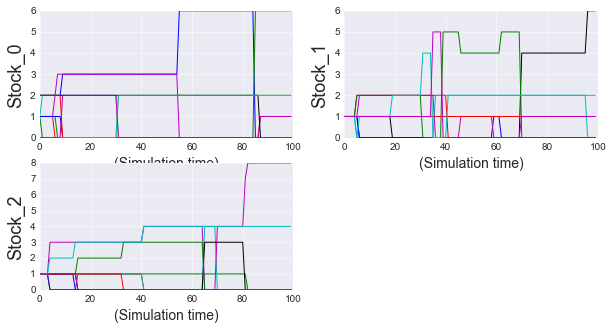

In [49]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

for trader in traderPortfolios['object_name'].unique():
    ax1.plot(tp_time, 
            traderPortfolios.query('object_name == "{}"'.format(trader))['stock_0'],
            label=trader)
    
for trader in traderPortfolios['object_name'].unique():
    ax2.plot(tp_time, 
            traderPortfolios.query('object_name == "{}"'.format(trader))['stock_1'],
            label=trader)
    
for trader in traderPortfolios['object_name'].unique():
    ax3.plot(tp_time, 
            traderPortfolios.query('object_name == "{}"'.format(trader))['stock_2'],
            label=trader)

ax1.set_xlabel('(Simulation time)', fontsize='14')
ax1.set_ylabel('Stock_0', fontsize='18')
ax2.set_xlabel('(Simulation time)', fontsize='14')
ax2.set_ylabel('Stock_1', fontsize='18')
ax3.set_xlabel('(Simulation time)', fontsize='14')
ax3.set_ylabel('Stock_2', fontsize='18')

#plt.legend(loc=2, fontsize='14')

## 2 Transactions
Using the Transactions and Objects tables, I then analyse the transactions made by traders. 

In [51]:
transactions = pd.read_sql_query("""
SELECT Transactions.id, Transactions.period, Transactors.role, Objects.object_name, Objects.object_type, Transactions.amount_of_product, Transactions.amount_of_money 
FROM Transactors JOIN Transactions JOIN Objects 
ON Transactors.transaction_id = Transactions.id and Transactors.transactor_id = Objects.id
""", conn)

The price of transactions is not recorded in the simulation. Therefore, I derive it by dividing the amount of money payed for a single transactions by the amount of stocks traded. 

In [52]:
transactions['price'] = transactions['amount_of_money'] / transactions['amount_of_product']

In [53]:
transactions.head()

,id,period,role,object_name,object_type,amount_of_product,amount_of_money,price
0,1,0,buyer,trader_3,trader,1.0,19.73125,19.73125
1,1,0,seller,trader_5,trader,1.0,19.73125,19.73125
2,1,0,stock,stock_0,stock,1.0,19.73125,19.73125
3,2,0,buyer,trader_7,trader,1.0,19.73125,19.73125
4,2,0,seller,trader_6,trader,1.0,19.73125,19.73125


### 2.1 Prices 
A stock can be traded at different prices at the same time by different traders. I therefore construct a seperate table which summarizes stocks prices over time. 

In [56]:
transactionTime = [n for n in range(100)]

In [83]:
stockPrices = {'period': transactionTime}
for stock in transactions.query('object_type == "stock"')['object_name'].unique():
    allPrices = []
    for period in transactionTime:
        pricesAtPeriod = []
        for price in transactions.query('object_name == "{}" and period == {}'.format(stock,period))['price']:
            pricesAtPeriod.append(price)
        if (not not pricesAtPeriod):
            allPrices.append(pricesAtPeriod)
        else:
            allPrices.append(False)
    stockPrices[stock] = allPrices

In [84]:
pricesOvertime = pd.DataFrame(stockPrices)
pricesOvertime

,period,stock_0,stock_1,stock_2
0,0,"[19.73125, 19.73125, 19.73125]",False,False
1,1,[21.0125],False,False
2,2,False,False,False
3,3,False,False,False
4,4,False,False,"[18.5525, 18.5525, 18.5525]"
5,5,False,"[18.9625, 18.9625]",False
6,6,[21.0125],"[18.3475, 18.3475]",False
7,7,[20.5],False,False
8,8,False,False,False
9,9,"[21.396875, 21.396875]",False,False


In [85]:
# To do plot prices over time

In [18]:
cur.close()
conn.close()